In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from tensorflow import keras

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop=set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import Constant

from tensorflow.keras.layers import Embedding, LSTM, Dense,SpatialDropout1D

In [2]:
rest_train = pd.read_csv("./Datasets/yelp_review_polarity_csv/fixed_train.csv")
rest_test = pd.read_csv("./Datasets/yelp_review_polarity_csv/fixed_test.csv")
rest_df=pd.concat([rest_train,rest_test])

In [3]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [21]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'], color = 'red')
    ax[0].plot(history.history['val_accuracy'], color = 'blue')

    ax[1].plot(history.history['loss'], color='red')
    ax[1].plot(history.history['val_loss'], color = 'blue')

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Learning Curves", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [4]:
rest_df['review']=rest_df['review'].apply(lambda x : remove_URL(x))
rest_df['review']=rest_df['review'].apply(lambda x : remove_html(x))
rest_df['review']=rest_df['review'].apply(lambda x : remove_emoji(x))
rest_df['review']=rest_df['review'].apply(lambda x : remove_punct(x))

In [5]:
embedding_dict={}
MAX_LEN=50
learning_rate=1e-5
batch_size = 64
epochs = 10

In [6]:
def create_corpus(df):
    corpus=[]
    for tweet in df['review']:
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
corpus=create_corpus(rest_df)

In [8]:
with open('./Datasets/glove.6B.100d.txt','r',encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [9]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

rest_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
word_index=tokenizer_obj.word_index

In [10]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in word_index.items():
    if i > num_words:
        continue  
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

In [11]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=learning_rate)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [12]:
train = rest_pad[:rest_train.shape[0]]
test = rest_pad[rest_train.shape[0]:]

In [13]:
X_train,X_test,y_train,y_test = train_test_split(train,rest_train['target'].values,test_size=0.20)

In [14]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), verbose=2)

Epoch 1/10
7000/7000 - 133s - loss: 0.6125 - accuracy: 0.6579 - val_loss: 0.5026 - val_accuracy: 0.7602
Epoch 2/10
7000/7000 - 131s - loss: 0.5257 - accuracy: 0.7413 - val_loss: 0.4705 - val_accuracy: 0.7796
Epoch 3/10
7000/7000 - 136s - loss: 0.5074 - accuracy: 0.7522 - val_loss: 0.4520 - val_accuracy: 0.7891
Epoch 4/10
7000/7000 - 139s - loss: 0.4937 - accuracy: 0.7606 - val_loss: 0.4411 - val_accuracy: 0.7950
Epoch 5/10
7000/7000 - 139s - loss: 0.4789 - accuracy: 0.7698 - val_loss: 0.4274 - val_accuracy: 0.8038
Epoch 6/10
7000/7000 - 140s - loss: 0.4650 - accuracy: 0.7770 - val_loss: 0.4149 - val_accuracy: 0.8094
Epoch 7/10
7000/7000 - 141s - loss: 0.4507 - accuracy: 0.7864 - val_loss: 0.4030 - val_accuracy: 0.8170
Epoch 8/10
7000/7000 - 139s - loss: 0.4388 - accuracy: 0.7927 - val_loss: 0.3949 - val_accuracy: 0.8228
Epoch 9/10
7000/7000 - 130s - loss: 0.4286 - accuracy: 0.7984 - val_loss: 0.3863 - val_accuracy: 0.8273
Epoch 10/10
7000/7000 - 134s - loss: 0.4211 - accuracy: 0.8032 -

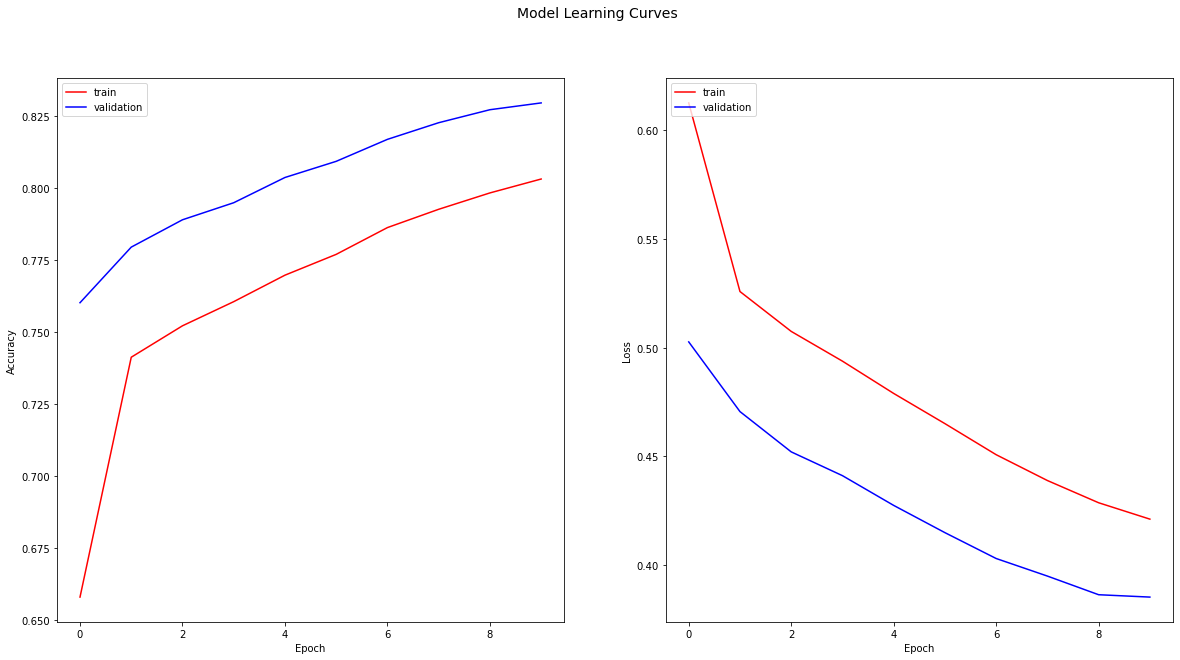

In [22]:
plot_learning_curves(history)

In [16]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(len(y_pre))

path = pd.read_csv("./Datasets/yelp_review_polarity_csv/fixed_test.csv")
original = path
original.to_csv('./Output/Predicted_dataset.csv')
predicted = pd.read_csv('./Output/Predicted_dataset.csv')
predicted['target'] = y_pre
predicted.to_csv('./Output/GloVe_Predicted_dataset.csv', index=False)